In [1]:
! pip install gymnasium stable-baselines3 wandb

In [1]:
import pandapower as pp
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
import numpy as np
from stable_baselines3 import PPO
import wandb
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import os

In [2]:
class SimpleTwoBus:
 
    def __init__(self, V_ext, P, Q, G, B, V_init, theta_init, V_bus1, theta_bus1):
        '''This class creates a simple 2-bus network.'''
        
        self.V_ext = V_ext
        self.P = P
        self.Q = Q
        self.G = G
        self.B = B
        self.V_init = V_init
        self.theta_init = theta_init
        self.V_bus1 = V_bus1
        self.theta_bus1 = theta_bus1
        self.net = pp.create_empty_network()
        self.create_two_bus_grid()
 
 
    def create_two_bus_grid(self):
   
        # Create two buses with initialized voltage and angle
        bus1 = pp.create_bus(self.net, vn_kv=1.0, name="Bus 1")
        bus2 = pp.create_bus(self.net, vn_kv=1.0, name="Bus 2")
   
        # Initialize voltage and angle for buses
        self.net.bus.loc[bus1, 'vm_pu'] = self.V_bus1
        self.net.bus.loc[bus1, 'va_degree'] = self.theta_bus1
        self.net.bus.loc[bus2, 'vm_pu'] = self.V_init
        self.net.bus.loc[bus2, 'va_degree'] = self.theta_init
   
        # create a line between the two buses
        pp.create_line_from_parameters(
            self.net,
            from_bus=0,
            to_bus=1,
            length_km=1.0,
            r_ohm_per_km=1/self.G,
            x_ohm_per_km=1/self.B,
            c_nf_per_km=0.0,
            g_us_per_km=0.0,
            max_i_ka=100.0,
        )
 
        # Create a transformer between the two buses
        # pp.create_transformer(self.net, bus1, bus2, std_type="0.25 MVA 20/0.4 kV")
   
        # Create a load at bus 2 with specified P and Q
        pp.create_load(self.net, bus2, p_mw=self.P, q_mvar=self.Q, name="Load")
   
        # Create an external grid connection at bus 1 with specified G and B
        pp.create_ext_grid(self.net, bus1, vm_pu=self.V_ext, name="Grid Connection")


In [3]:
class GridEnv(gym.Env):
    def __init__(self,V_ext = 1.0, G = 100, B = 10, k_limit = 3, max_iteration=50, termination_counter=10):


        self.observation_space = spaces.Box(low = np.array([0.5,-90, 0]), high = np.array([2, 90, max_iteration+1]), dtype=np.float32) #[V_init, theta_init, number_iterations]
        
        self.action_space = spaces.Box(low=np.array([-0.5, -50]), high=np.array([0.5, 50]), dtype=np.float32)

        self.k_limit = k_limit
        self.termination_counter = termination_counter
        self.max_iteration = max_iteration


        self.G = G
        self.B = B
        self.V_ext = V_ext

        #initialize network
        self.state, info = self.reset()

    def create_feasible_Ybusnet(self):

        YbusNet = SimpleTwoBus(self.V_ext,self.P,self.Q,self.G,self.B,self.V_bus1,self.theta_bus1, 0.98, 0.5) #just to create a sparse Ybus matrix
        net = YbusNet.net

        return net


    
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        if seed is not None:
            self.seed(seed)

        self.counter = 0
        self.done = False
        self.terminated = False
        self.state = np.zeros(3)

        self.P = 0.9 #np.random.uniform(low= 0, high=10)
        self.Q = 0.6 #np.random.uniform(low = 0, high =10)

        self.V_bus1 = 1.0#np.random.uniform(low = 0.85, high = 1.15, size=1)
        self.theta_bus1 = 0#np.random.uniform(low = -45, high = 45, size=1)
        self.V = np.random.uniform(low = 0.5, high = 2, size=1) # initial guess
        self.theta = np.random.uniform(low = -90, high = 90, size=1) # initial guess


        Net = SimpleTwoBus(self.V_ext,self.P,self.Q,self.G,self.B,self.V,self.theta, self.V_bus1, self.theta_bus1)
        self.net = Net.net

        self.Ybus = self.calculate_Ybus()

        iterations = self.perform_NR_step()

        
        self.update_state(iterations)


        return self.state, {}




    def calculate_Ybus(self):


        Ybusnet = self.create_feasible_Ybusnet()
        pp.runpp(Ybusnet, max_iteration = self.max_iteration, tolerance_mva=1e-5)
        Ybus = Ybusnet._ppc["internal"]["Ybus"]



        return Ybus


    def calculate_complex_V(self, V, theta):
        complex_V = V*np.exp(1j*theta) #rectangular form

        return complex_V
    
    def update_V(self, action):


        new_V = self.V - action[0]
        new_theta = self.theta - action[1]


        # maybe try different way of scaling the actions back when they exceed the limits?
        #defines the action constraints -> this might not be the correct way to do this!
        if new_V[0] > 2:
            new_V[0] = 2 
        if new_V[0] < 0.5:
            new_V[0] = 0.5
        if new_theta[0] > 90:
            new_theta[0] = 90
        if new_theta[0] < -90:
            new_theta[0] = -90
        


        complete_V = np.zeros(2)
        complete_theta = np.zeros(2)

        complete_V[0] = self.V_bus1
        complete_V[1] = new_V[0]
        complete_theta[0] = self.theta_bus1
        complete_theta[1] = new_theta[0]


        self.complex_V = self.calculate_complex_V(complete_V, complete_theta)



        self.V = new_V

        self.theta = new_theta





    def calculate_residual(self, action):

        # net = self.net.deepcopy()  # Keep the network unchanged

        self.update_V(action) #rectangular form
        # print(f"{self.complex_V=}")

        # print(f"{self.Ybus[0,1]=}")

        term2 = self.Ybus@self.complex_V
        term2_complex_conj = np.conj(term2)

        term1 = self.complex_V@term2_complex_conj

        F = self.P + 1j*self.Q - term1

        delta_P = np.real(F)
        delta_Q = np.imag(F)

        residual = np.array([delta_P, delta_Q])



        return residual


    def perform_NR_step(self):

        net = self.net.deepcopy()  # Keep the network unchanged

        try:
            pp.runpp(net, max_iteration = self.max_iteration, tolerance_mva = 1e-5, init_vm_pu=self.V,init_va_degree=self.theta)
            # print(f"{net.res_bus[['va_degree']].values=}")
            # print(f"{net.res_bus[['vm_pu']].values=}")
        

            iterations = net._ppc["iterations"]
        except:
            iterations = 50
            # print(f"{net.res_bus[['va_degree']].values=}")
            # print(f"{net.res_bus[['vm_pu']].values=}")

        return iterations
        

    

    def calculate_reward(self, residual):


        reward = np.linalg.norm(residual)

        return -reward
    

    def update_state(self, iterations):
        
        self.state[0] = self.V[0]
        self.state[1] = self.theta[0]
        self.state[2] = iterations


    def step(self, action):


        self.counter += 1
        # action = [delta_V, delta_theta]

        # perform action
        residual = self.calculate_residual(action)
        # print(f"{residual=}")

        # calcualate reward
        reward = self.calculate_reward(residual)

        iterations = self.perform_NR_step()

        #update state:
        self.update_state(iterations)

        if iterations <= self.k_limit:
            self.done = True
            return self.state, reward, self.done, self.terminated, {}

        

        if self.counter == self.termination_counter:
            self.terminated = True
            return self.state, reward, self.done, self.terminated, {}

        return self.state, reward, self.done, self.terminated, {}


  

    def render(self):
        pass

/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


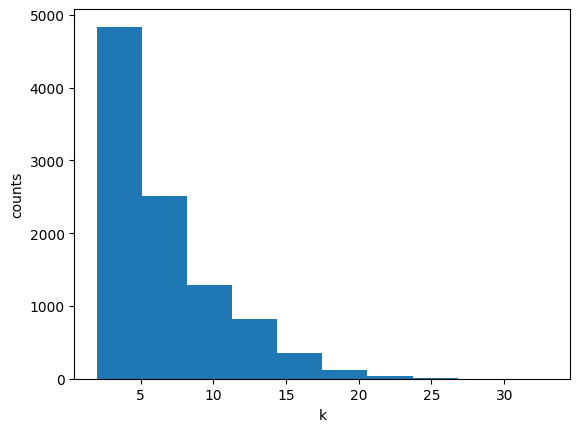

Initial State: [  1.21384304 -56.31770724  14.        ]

Action Taken: [ 0.03 15.  ]
Next State: [  1.18384304 -71.31770724   8.        ]
Reward: -37.13398868869652
Done: False


In [9]:
# Test run


env = GridEnv()

k_list = []
for i in range(int(10000)):

    state, info = env.reset()
    k = state[-1]
    k_list.append(k)


#view the distribution of hard and easy cases
plt.figure()
plt.hist(k_list)
plt.xlabel("k")
plt.ylabel("counts")
plt.show()

state,info = env.reset()

print("Initial State:", state)
# env.render()

# Define a sample action within the specified ranges
action = np.array([0.03, 15.0], dtype=np.float32)

# Take a step in the environment using the sample action
next_state, reward, done, terminated, info = env.step(action)

# Print the results
print("\nAction Taken:", action)
print("Next State:", next_state)
# env.render()
print("Reward:", reward)
print("Done:", done)

In [4]:
class WandbCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(WandbCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        # Check if the episode is done
        if self.locals["dones"][0]:
            # Log the episode return (sum of rewards)
            episode_reward = self.locals["infos"][0].get("episode", {}).get("r", 0)
            episode_length = self.locals["infos"][0].get("episode", {}).get("l", 0)
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            wandb.log({"episode_reward": np.mean(self.episode_rewards[:-100]), "episode_length": np.mean(self.episode_lengths[:-100])})
            # print(f"{episode_reward=}")

        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [5]:
# train an RL agent on the environment from above

# Create log dir
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

wandb.init(project="grid-env-training")

env = GridEnv()
env = Monitor(env, log_dir)
lr = 5e-4
total_timesteps = 1e6

model = PPO("MlpPolicy", env, verbose=1, learning_rate = lr)
model.learn(total_timesteps=total_timesteps, callback = WandbCallback(check_freq=1000, log_dir=log_dir))
model.save(f"PPO_{lr=}_{total_timesteps=}")

wandb.finish()



wandb: Currently logged in as: lindsayspoor (lindsayspoor-rlg). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
Wrapping the env in a DummyVecEnv.


/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ictwi_allia

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -238.08
Saving new best model to log/best_model
Num timesteps: 2000
Best mean reward: -238.08 - Last mean reward per episode: -259.68
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.48     |
|    ep_rew_mean     | -253     |
| time/              |          |
|    fps             | 57       |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 3000
Best mean reward: -238.08 - Last mean reward per episode: -227.59
Saving new best model to log/best_model
Num timesteps: 4000
Best mean reward: -227.59 - Last mean reward per episode: -228.37
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.98        |
|    ep_rew_mean          | -220        |
| time/                   |             |
|    fps                  | 5

episode_length,████▇▆▆▆▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
episode_reward,▁▄▆▆▆▇▇▇▇▇▇▇████████████████████████████
episode_length,6.66554
episode_reward,-85.93766


In [9]:

def evaluate_model(model, num_evaluations, env, plot, max_timesteps=10):
    
    evaluation_results = []

    for i in range(num_evaluations):
        state, info = env.reset()
        V_start = state[0]
        theta_start = state[1]
        done = False
        timesteps = 0
        trace = []

        for t in range(max_timesteps):
            # while not done:
            # print(f"{trace=}")
            action, _ = model.predict(state, deterministic=True)

            next_state, reward, done, terminated, info = env.step(action)

            trace.append({
                "state": state.copy(),
                "action": action.copy(),
                "reward": reward.copy(),
                "done": done,
                "terminated": terminated,
                "next_state": next_state.copy()
            })
            state = next_state

            timesteps += 1



            if done:
                V_end = state[0]  # Assuming V_end is the first element of the state
                theta_end = state[1]  # Assuming theta_end is the second element of the state
                break
            if terminated:
                V_end = state[0]  # Assuming V_end is the first element of the state
                theta_end = state[1]  # Assuming theta_end is the second element of the state
                break

        evaluation_results.append({
                "V_start": V_start,
                "theta_start": theta_start,
                "V_end": V_end,
                "theta_end": theta_end,
                "timesteps": timesteps,
                "residual_end": reward,
                "trace": trace
            })


    # Convert results to a numpy array for easier plotting
    V_start_values = np.array([result["V_start"] for result in evaluation_results])
    theta_start_values = np.array([result["theta_start"] for result in evaluation_results])
    timesteps_values = np.array([result["timesteps"] for result in evaluation_results])

    if plot:
        # Plotting
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(theta_start_values, V_start_values, c=timesteps_values, cmap='viridis')
        plt.colorbar(scatter, label='Number of Timesteps')
        plt.xlabel('Theta_init')
        plt.ylabel('V_init')
        # plt.title('Evaluation of Trained Model')
        plt.show()

        

    return evaluation_results

In [10]:
def plot_a_trace(evaluation_results, index):
    # Convert results to a numpy array for easier plotting
    V_start_values = np.array([result["V_start"] for result in evaluation_results])
    theta_start_values = np.array([result["theta_start"] for result in evaluation_results])
    timesteps_values = np.array([result["timesteps"] for result in evaluation_results])



    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(theta_start_values, V_start_values, c=timesteps_values, cmap='viridis', alpha=0.4)

    trace = evaluation_results[index]["trace"]
    # print(f"{evaluation_results=}")
    # print(f'{trace=}')

    V_trace = [step["state"][0] for step in trace]

    theta_trace = [step["state"][1] for step in trace]

    k_trace = [step["state"][2] for step in trace]
    residual_trace = [step["reward"] for step in trace]

    plt.plot(theta_trace, V_trace, color="black")
    plt.scatter(theta_trace, V_trace, color="black")

    plt.annotate(f'res={residual_trace[0]:.2f},\n k={k_trace[0]}', (theta_trace[0], V_trace[0]),
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=5)
    plt.annotate(f'res={residual_trace[-1]:.2f},\n k={k_trace[-1]}', (theta_trace[-1], V_trace[-1]),
                        textcoords="offset points", xytext=(0,5), ha='center', fontsize=5)
      
    if len(list(V_trace))==10:
        plt.scatter(theta_trace[-1], V_trace[-1], color="red")


    plt.colorbar(scatter, label='Number of Timesteps')
    plt.xlabel('Theta')
    plt.ylabel('V')
    # plt.title('Evaluation of Trained Model')
    plt.show()



In [ ]:
env = GridEnv()
num_evaluations = 10000
plot = True
lr = 5e-4
total_timesteps = 1e6
#best model results are with this learning rate!

model = PPO.load(f"PPO_lr={lr}_total_timesteps={total_timesteps}")

evaluation_results = evaluate_model(model, num_evaluations, env, plot)


/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/miniconda3/envs/ictwi_alliander_py312/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [ ]:
plot_a_trace(evaluation_results, index=8)